Reloading modules sometimes causes errors. It's easier to just restart the notebook kernel and run from the start every time.

## Setup environment

In [1]:
checkpoint_dir="checkpoints"
if 'google.colab' in str(get_ipython()): #type: ignore
    COLAB = True
    print('Running on colab')
    %cd /content/
    !git clone https://github.com/TeamDman/Vehicular-Game-Theory
    %cd /content/Vehicular-Game-Theory/platoongame
    !git pull

    from utils import get_device
    import torch
    assert get_device() == torch.device("cuda")

    use_gdrive_checkpoints = True #@param {type:"boolean"}
    if use_gdrive_checkpoints:
        from google.colab import drive #type: ignore
        drive.mount('/content/drive')

        !mkdir -p /content/drive/MyDrive/checkpoints
        checkpoints_dir = "/content/drive/MyDrive/checkpoints"
else:
    COLAB = False
    print('Not running on colab')

Not running on colab


## Configuration

### Seed RNG

In [2]:
import random
random_seed = 42 #@param {type:"integer"}
random.seed(random_seed)
import torch
torch.manual_seed(random_seed)

### Vehicle provider config

In [3]:
from vehicles import JsonVehicleProvider, RandomVehicleProvider, RubbishVehicleProvider


provider = "random" #@param ["random", "json", "rubbish"]
if provider == "json":
  vehicle_provider = JsonVehicleProvider("../subgame/python/solutions.json")
elif provider == "random":
  vehicle_provider=RandomVehicleProvider(
    # this affects model shape
    num_max_vulns=7 #@param {type:"integer"}
    ,
    prob_mu=0.5 #@param {type:"number"}
    ,
    prob_sigma=0.25 #@param {type:"number"}
    ,
    sev_mu=2 #@param {type:"number"}
    ,
    sev_sigma=1 #@param {type:"number"}
    ,
  )
elif provider == "rubbish":
  vehicle_provider=RubbishVehicleProvider()
else:
  raise ValueError("unknown provider chosen")

In [4]:
from pprint import pprint
import dataclasses
pprint(dataclasses.asdict(vehicle_provider.next()))

{'in_platoon': False,
 'vulnerabilities': ({'prob': 0.5841726064682007,
                      'severity': 2,
                      'state': <CompromiseState.NOT_COMPROMISED: 1>},)}


### Game config

In [5]:
from game import GameConfig

game_config=GameConfig(
    max_vehicles=10 #@param {type:"integer"}
    ,
    cycle_enabled=False #@param {type:"boolean"}
    ,
    cycle_every=5 #@param {type:"integer"}
    ,
    cycle_allow_platoon=False #@param {type:"boolean"}
    ,
    cycle_num=3 #@param {type:"integer"}
)

### Attacker agent config

In [6]:
from agents import AttackerAgent, PassiveAgent, BasicAttackerAgent
from game import State
from vehicles import CompromiseState

attacker_ = "humanish" #@param ["passive", "humanish"]
if attacker_ == "passive":
  attacker = PassiveAgent()
elif attacker_ == "humanish":
  def get_attacker_utility(self:AttackerAgent, state: State) -> float:
    members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
    comp = [1 for v in members if any([True if vuln.state != CompromiseState.NOT_COMPROMISED else False for vuln in v.vulnerabilities])]
    return len(comp)

  attacker = BasicAttackerAgent(
    attack_limit=1 #@param {type:"integer"}
    ,
    attack_interval=5 #@param {type:"integer"},
    ,
    utility_func=get_attacker_utility
  )
else:
  raise ValueError("unknown attacker chosen")

### Defender agent config

In [7]:
from agents import WolpertingerDefenderAgent, RandomDefenderAgent
from models import StateShapeData
from vehicles import Vehicle, Vulnerability

def get_defender_utility(self:WolpertingerDefenderAgent, state: State) -> float:
    members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]

    ## return the severity of the vulns in the platoon
    return sum([sum([vuln.severity for vuln in vehicle.vulnerabilities]) for vehicle in members])

    ## return how many members are in the platoon
    # if len(members) == 5:
    #     return 10.0
    # else:
    #     return 0.0

    ## return platoon size if not compromised
    # comp = [1 for v in members for vuln in v.vulnerabilities if vuln.state != CompromiseState.NOT_COMPROMISED]
    # if len(comp) > 0: return 0
    # return len(members)

load_checkpoint = False #@param {type:"boolean"}
defender=WolpertingerDefenderAgent(
    state_shape_data=StateShapeData(
        num_vehicles=game_config.max_vehicles,
        num_vehicle_features=Vehicle.get_shape()[0],
        num_vulns=vehicle_provider.max_vulns,
        num_vuln_features=Vulnerability.get_shape()[0]
    ),
    learning_rate=0.001 #@param {type:"number"}
    ,
    num_proposals=100 #@param {type: "integer"}
    ,
    utility_func=get_defender_utility
    ,
    ou_theta = 0.0 #@param {type: "number"}
    ,
    ou_mu = 0.0 #@param {type: "number"}
    ,
    ou_sigma = 3 #@param {type: "number"}
    ,
    epsilon_decay_time=50000 #@param {type: "integer"}
)

random_defender = RandomDefenderAgent()
random_defender.get_utility = get_defender_utility.__get__(random_defender, get_defender_utility)


if load_checkpoint:
  defender.load(
    dir=checkpoints_dir,
    prefix="2022-10-13 2258-27 054659" #@param {type: "string"}
)

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Baseline evaluation

untrained defender


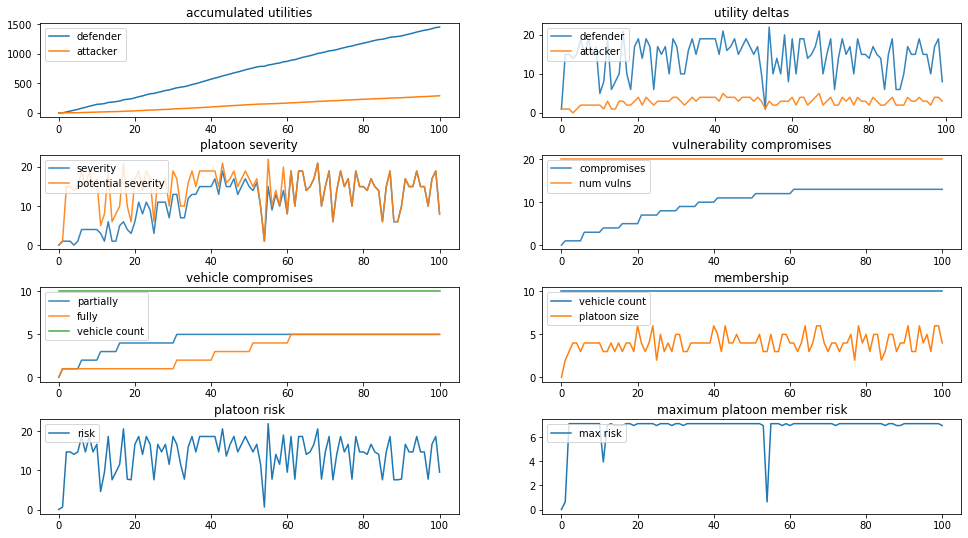

In [8]:
from agents import RandomDefenderAgent
from evaluation import get_episode_metrics

print("untrained defender")
get_episode_metrics(
    defender_agent=defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

random defender


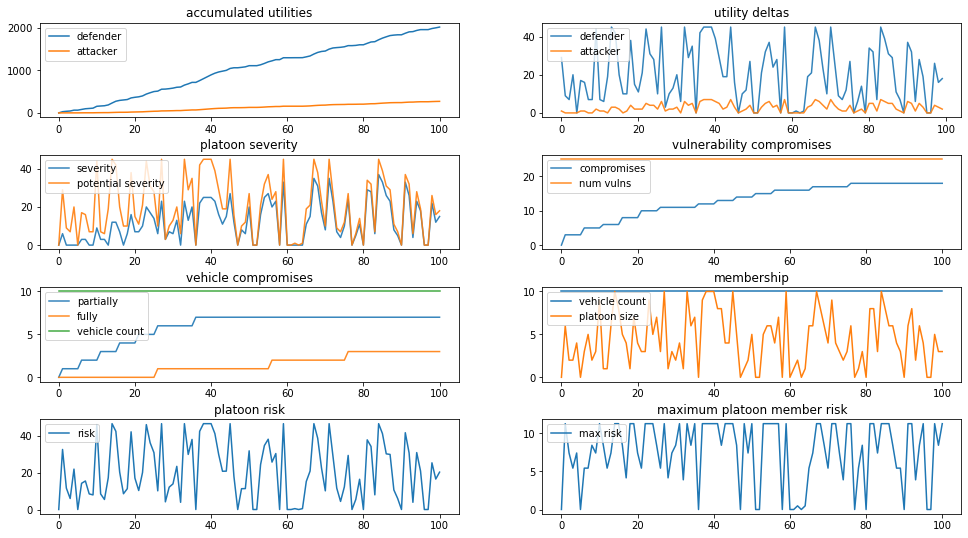

In [9]:
print("random defender")
get_episode_metrics(
    defender_agent=random_defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

## Training

### Replay memory config

In [10]:
from memory import DequeReplayMemory

memory = DequeReplayMemory(
    capacity=100000 #@param {type:"integer"}
)

### Training metrics tracker config

In [11]:
from metrics import TrainingMetricsTracker
tracker = TrainingMetricsTracker()

### Trainer config

In [26]:
from training import WolpertingerDefenderAgentTrainer, WolpertingerDefenderAgentTrainerConfig
trainer = WolpertingerDefenderAgentTrainer(WolpertingerDefenderAgentTrainerConfig(
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    attacker_agent=attacker,
    defender_agent=defender,
    checkpoint_interval=-1 #@param {type:"integer"}
    ,
    memory=memory,
    metrics_tracker=tracker,
    batch_size=50 #@param {type:"integer"}
    ,
    train_steps=2500 #@param {type:"integer"}
    ,
    exploration_per_step=5 #@param {type:"integer"}
    ,
    warmup_replay=2000 #@param {type:"integer"}
    ,
    max_steps_per_episode=5 #@param {type:"integer"}
    ,
    attacker_headstart=3 #@param {type:"integer"}
    ,
    update_policy_interval=1 #@param {type:"integer"}
    ,
    policy_update_type="soft" #@param ["soft", "hard"]
    ,
    reward_gamma = 0.99 #@param {type:"number"}
    ,
    soft_update_tau = 0.001 #@param {type:"number"}
))

### Generate warmup samples from random actions

In [13]:
trainer.warmup()

Warming up...


  0%|          | 0/2000 [00:00<?, ?it/s]

Warmup complete~!


In [14]:
# arbitrary number, but we need to be sure there are enough transitions that have rewards
# lost a lot of time debugging because of this
reward_expectation=100 #@param {type:"integer"}
reward_expectation_steps = 1000 #@param {type:"integer"}
assert sum([e.reward for e in memory.sample(min(reward_expectation_steps, len(memory)))]) > reward_expectation

(array([400., 294., 303., 277., 266., 191., 153.,  83.,  27.,   6.]),
 array([ 0. ,  9.4, 18.8, 28.2, 37.6, 47. , 56.4, 65.8, 75.2, 84.6, 94. ]),
 <BarContainer object of 10 artists>)

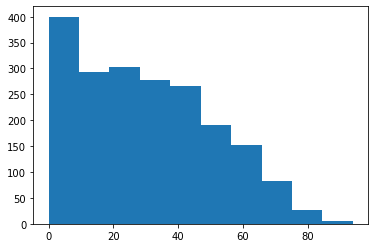

In [15]:
import matplotlib.pyplot as plt
rewards = [float(x.reward) for x in memory]
plt.hist(rewards)

In [16]:
# ensure that there are many more non-zero rewards than zero rewards
for _ in range(5):
    for x in memory.sample(len(memory)):
        if x.reward > 0:
            memory.push(x)

(array([7034., 9408., 9696., 8864., 8512., 6112., 4896., 2656.,  864.,
         192.]),
 array([ 0. ,  9.4, 18.8, 28.2, 37.6, 47. , 56.4, 65.8, 75.2, 84.6, 94. ]),
 <BarContainer object of 10 artists>)

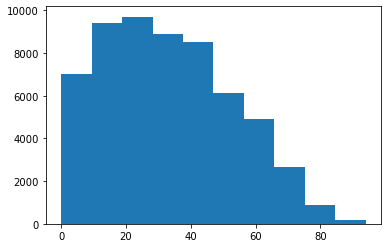

In [17]:
rewards = [float(x.reward) for x in memory]
plt.hist(rewards)

(array([139., 106., 139., 256., 158., 121.,  27.,  23.,  18.,  13.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

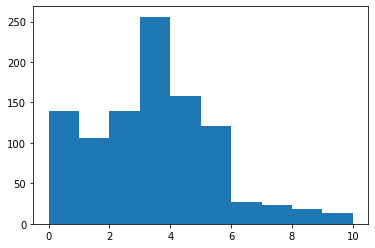

In [18]:
check_vulns = 1000
comps = [
    x.state.vulnerabilities[:,:,:,3].sum().item()
    for x in memory.sample(check_vulns)
]
plt.hist(comps)

### Perform training

In [27]:
# todo: ensure agent is actually getting reported estimated policy loss
# agent seems to be getting no rewards when evaluated, so why is expected policy loss reporting it should be getting rewards?
# todo: investigate adaptive learning rate, lower learning rate
trainer.train()

Warming up...


0it [00:00, ?it/s]

Warmup complete~!


  0%|          | 0/2500 [00:00<?, ?it/s]

train step 0000 reward={max=19.0000, min=19.0000, mean=19.0000} optimizing loss=49.7324 diff={max=19.0674, min=00.6520, mean=05.2378} policy_loss=-51.7223 policy updated! 
train step 0001 reward={max=45.0000, min=45.0000, mean=45.0000} optimizing loss=39.3376 diff={max=21.6222, min=00.0229, mean=04.5949} policy_loss=-55.5754 policy updated! 
train step 0002 reward={max=27.0000, min=27.0000, mean=27.0000} optimizing loss=27.7198 diff={max=18.7949, min=00.1631, mean=03.8785} policy_loss=-54.3735 policy updated! 
train step 0003 reward={max=29.0000, min=29.0000, mean=29.0000} optimizing loss=21.8484 diff={max=10.9273, min=00.3485, mean=03.7564} policy_loss=-52.8136 policy updated! 
train step 0004 reward={max=19.0000, min=19.0000, mean=19.0000} optimizing loss=24.7077 diff={max=13.5388, min=00.1327, mean=04.0376} policy_loss=-53.0252 policy updated! 
train step 0005 reward={max=25.0000, min=25.0000, mean=25.0000} optimizing loss=26.6568 diff={max=15.2710, min=00.5656, mean=04.0927} policy

KeyboardInterrupt: 

In [20]:
# todo: predict a distribution instead of single actions if attacker behaviour is nondeterministic

In [21]:
attempt_gpu_mem_flush = False #@param {type:"boolean"}
if attempt_gpu_mem_flush:
    import torch
    torch.cuda.empty_cache()
    import gc
    gc.collect()
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

### View training metrics

No stats to plot below loss threshold 20
No stats to plot below loss threshold 5
No stats to plot below loss threshold 1


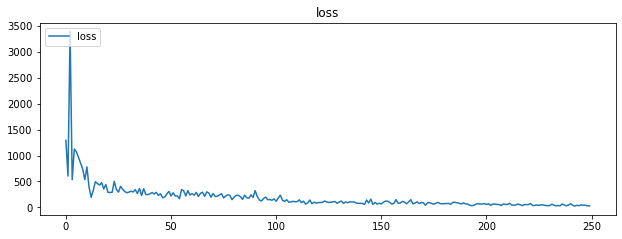

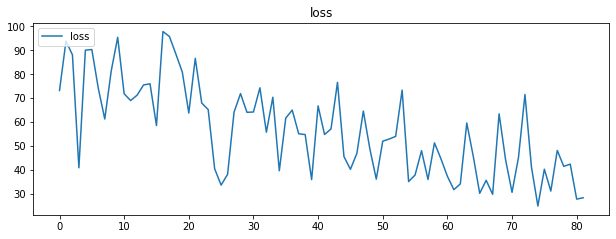

In [22]:
tracker.plot()
tracker.plot(loss_threshold=100)
tracker.plot(loss_threshold=20)
tracker.plot(loss_threshold=5)
tracker.plot(loss_threshold=1)

## Evaluation

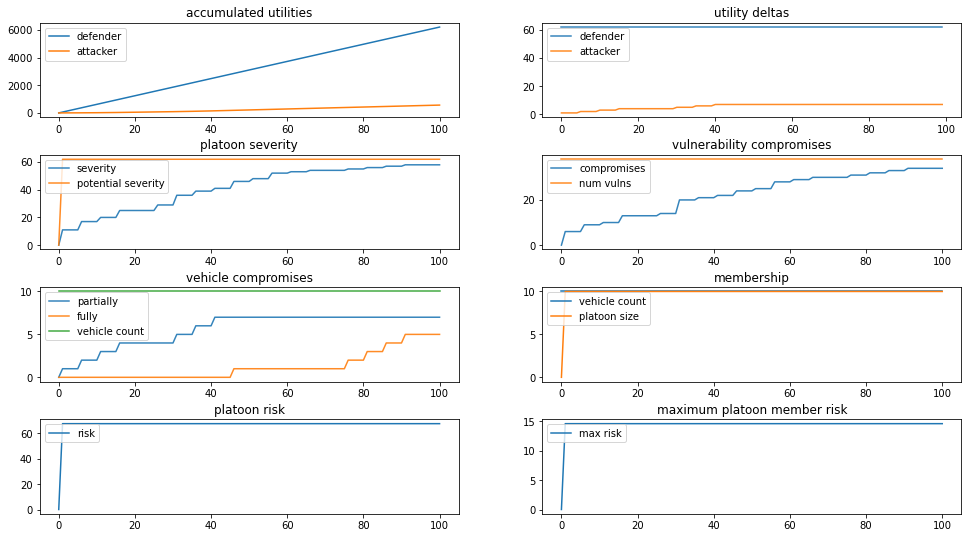

In [28]:
get_episode_metrics(
    defender_agent=defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

In [24]:
from evaluation import sample_model_outputs
sample_model_outputs(
    defender_agent=defender,
    memory=memory,
)

action.members tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.],
       grad_fn=<SumBackward1>)
q_pred tensor([48.6383, 43.2811, 63.2663, 39.0873, 49.7996, 58.5153, 81.1064, 71.0404,
        54.1287, 44.9771], grad_fn=<ReshapeAliasBackward0>)
batch.reward tensor([ 6., 34., 54., 19., 27.,  0., 41., 55., 39.,  1.])
pred reward err tensor([42.6383,  9.2811,  9.2663, 20.0873, 22.7996, 58.5153, 40.1064, 16.0404,
        15.1287, 43.9771], grad_fn=<SubBackward0>)


## Manually checkpoint model

In [25]:
from utils import get_prefix

manual_checkpoint = False #@param {type:"boolean"}
if manual_checkpoint:
    prefix = get_prefix()
    defender.save(dir=checkpoints_dir, prefix=prefix)
    trainer.config.dump(dir=checkpoints_dir, prefix=prefix)
    print(prefix)